<a href="https://colab.research.google.com/github/AndreaToPaz/sentiment-analysis/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de sentimientos con BERT
En este cuaderno, realizaremos las siguientes actividades
1.   Cargar un conjunto de datos
2.   Pre procesaer el conjunto de datos, previamente cargado
1.   Cargar el modelo BERT que se encuentra disponible en TensorFlow Hub
2.   Construir un modelo personalizado, utilizando BERT
1.   Entrenar el modelo creado
2.   Realizar una evalución en el modelo creado











Cargamos las dependencias a utilizar

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install clean_text
!pip install -q tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#TensorFlow
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.python import metrics

#scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

#Pypi 
from cleantext import clean
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

#Google Colab
from google.colab import drive  #Permite acceder a los datos en google drive, AUTENTIFICACIÓN ES NECESARIA
drive.mount('/content/drive')
tf.get_logger().setLevel('ERROR')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Leemos el conjunto de datos que agregarmos a nuestro Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/data.tsv', sep='\t')
print(df)
df = df.drop('id', axis=1)
print(df)

        id                                              tweet     label 
0        1  El Atlético resignado a perder HASHTAG 😔  http...  tristeza 
1        2  Leer proporciona una mejor visión del mundo 🤓 ...   alegria 
2        3  Amo a Arya Stark por encima de todas las cosas...   alegria 
3        4  Gracias HASHTAG es increíble que una niña logr...     otros 
4        5  Solo siento que hayamos perdido 24 escaños de ...  tristeza 
...    ...                                                ...        ...
5881  5882  Pequeños gestos que puedes hacer por el medio ...     otros 
5882  5883  ¿Sabías que de las dos coronaciones que se cel...     otros 
5883  5884  Mientras reflexionamos sobre lo duro que es es...       ira 
5884  5885  La fachada de la catedral de Notre Dame fue “s...  tristeza 
5885  5886  Estaba sufriendo el Barsa pero si tienes a Mes...   alegria 

[5886 rows x 3 columns]
                                                  tweet     label 
0     El Atlético resignado a pe

Observamos la cantidad de datos por categoria

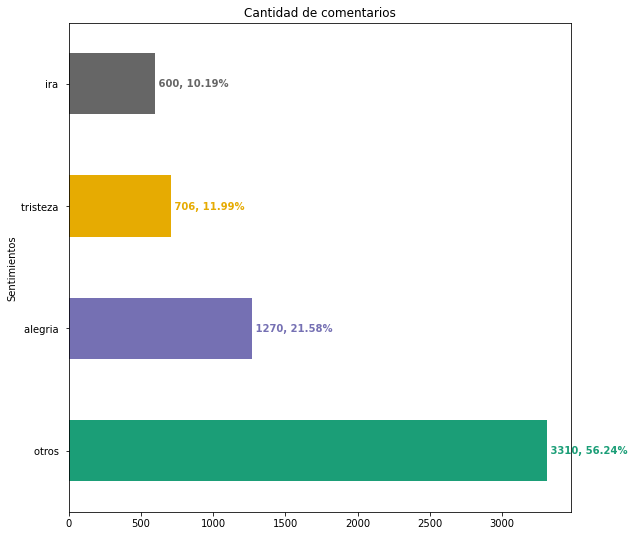

In [ ]:
comment_target = 'tweet'
target = 'label '
num_classes = len(df[target].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df[target].value_counts().plot.barh(title="Cantidad de comentarios", 
                                                 ylabel="Sentimientos",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df[target].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

Preprocesar los comentarios

In [ ]:
def clean_text(text) :
    """
    Purpose: 
    Se eliminar:  URLs y  emojis.
    """
    text = clean(text, no_emoji=True)
    text = clean(text, no_urls=False, replace_with_url="<URL>")
    text = re.sub(";",' ', text)
    text = re.sub(' +', ' ',text)
    text = re.sub("\r|\n",' ', text)
    text = re.sub(r'@\w+', '', text)
    return text
# end def

In [ ]:
df[comment_target ] = df[comment_target].apply(clean_text)
print(df)

                                                  tweet     label 
0     el atletico resignado a perder hashtag https:/...  tristeza 
1     leer proporciona una mejor vision del mundo fe...   alegria 
2     amo a arya stark por encima de todas las cosas...   alegria 
3     gracias hashtag es increible que una nina logr...     otros 
4     solo siento que hayamos perdido 24 escanos de ...  tristeza 
...                                                 ...        ...
5881  pequenos gestos que puedes hacer por el medio ...     otros 
5882  sabias que de las dos coronaciones que se cele...     otros 
5883  mientras reflexionamos sobre lo duro que es es...       ira 
5884  la fachada de la catedral de notre dame fue "s...  tristeza 
5885  estaba sufriendo el barsa pero si tienes a mes...   alegria 

[5886 rows x 2 columns]


Se cambian las categorias por valores numericos, es decir, alegria, ira, tristeza y otros, se cambiara por valores numericos, cantidad - 1.

In [ ]:
LE = LabelEncoder()
df[target]= LE.fit_transform(df[target].values)

Usamos la libreria scikit-learn para dividir los datos en entrenamiento y pruebas, en este caso la division es de 80% para entrenamiento y 20% para pruebas

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df[comment_target],df[target] , test_size=0.20)

Construir el modelo utilizando el modelo BERT que se encuentra en TensorFlow Hub

In [ ]:
#Direcciones de los modelo en TensorFlow HUB
model_name = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4'
preprocessor_model_name = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

#Funcion para crear el modelo 
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(preprocessor_model_name, name='Prepocesamiento')

    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(model_name, trainable=True, name='Modelo_BERT')

    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1, name='Capa_Dropout')(net)
    net = tf.keras.layers.Dense(128, activation='relu', name='Capa_Densa')(net)
    net =  tf.keras.layers.Dense(num_classes, activation='softmax', name='Clasificador')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

Observamos la estructura del modelo creado

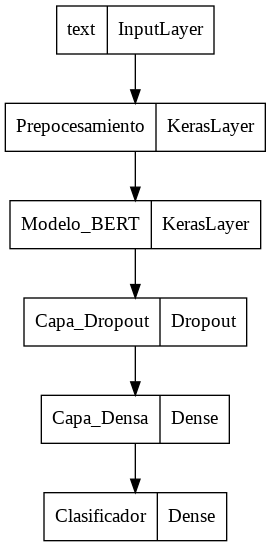

In [ ]:
tf.keras.utils.plot_model(classifier_model)

Para compilar el modelo, es necesario seleccionar una funcion de perdida, asi como un optimizador y las metricas para la evaluacion de rendimimiento

In [ ]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = tf.keras.metrics.SparseCategoricalAccuracy()

classifier_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss = LOSS,
    metrics = METRICS
)

Entrenemos el modelo

In [ ]:
size = 16
n_epochs = 6
history = classifier_model.fit(x_train, 
                      y_train, 
                      batch_size = size,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test))

Epoch 1/6
295/295 [==============================] - 163s 500ms/step - loss: 0.9204 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.8447 - val_sparse_categorical_accuracy: 0.6401
Epoch 2/6
295/295 [==============================] - 146s 496ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.7815 - val_sparse_categorical_accuracy: 0.6885
Epoch 3/6
295/295 [==============================] - 146s 496ms/step - loss: 0.4699 - sparse_categorical_accuracy: 0.8246 - val_loss: 0.8760 - val_sparse_categorical_accuracy: 0.6952
Epoch 4/6
295/295 [==============================] - 146s 495ms/step - loss: 0.3259 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.9479 - val_sparse_categorical_accuracy: 0.7029
Epoch 5/6
295/295 [==============================] - 146s 495ms/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9227 - val_loss: 1.0261 - val_sparse_categorical_accuracy: 0.6927
Epoch 6/6
295/295 [==============================] - 146s 495ms/step - loss: 0.1483 -

Evaluación de rendimiento


In [ ]:
y_pred = classifier_model.predict(x_test, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

74/74 [==============================] - 12s 154ms/step


In [ ]:
target_names = ['Alegria', 'Ira', 'Otros', 'Tristeza']
print(classification_report(LE.inverse_transform(y_test), LE.inverse_transform(y_pred_bool), target_names=target_names))

              precision    recall  f1-score   support

     Alegria       0.65      0.61      0.63       262
         Ira       0.46      0.47      0.46       124
       Otros       0.75      0.77      0.76       636
    Tristeza       0.68      0.67      0.68       156

    accuracy                           0.69      1178
   macro avg       0.63      0.63      0.63      1178
weighted avg       0.69      0.69      0.69      1178



Predicción

In [ ]:
example = ["me gusta mucho comer torta"]
y_pred = classifier_model.predict(tf.constant(example))
print(y_pred)

1/1 [==============================] - 1s 720ms/step
[[0.13919657 0.00351136 0.8177002  0.03959198]]
